In [1]:
#Building makemore Part 2: MLP(https://youtu.be/TCH_1BHY58I?si=uWMn6c-Wq1nPwAcX)

In [2]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [3]:
words = open('names.txt', 'r').read().split()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = ['.'] + [chr(i + ord('a')) for i in range(26)]
stoi = {s:i for i,s in enumerate(chars)}
itos = {stoi[v]:v for v in stoi}

In [86]:
def crete_traininng_data(words, context_length):
    xs = []
    ys = []
    for w in words:
        #print(w)
        context = [stoi['.']]*context_length
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            #print(f'{''.join([itos[i] for i in context])} -> {itos[ix]}')
            context = context[1:] + [ix] # rolling window
    return torch.tensor(xs), torch.tensor(ys)
X,Y = crete_traininng_data(words,3)

In [17]:
#considering it as a matrix manipulation
#(one hot generates a tensor with the same number of rows as the input and the same number of colums as num classes
#where for every row all the elements are 0 except for the one indexed by the input[row number] that equals 1)
def embad_element(element, space, num_classes):
    element_enc = F.one_hot(torch.tensor(element), num_classes).float()
    #ex
    #selector = F.one_hot(torch.tensor([1,2]), 3).float()
    #selector
    #tensor([[0., 1., 0.],
    #        [0., 0., 1.]])
    #space = [[a,b],[c,d],[e,f]]
    #target = torch.tensor([[0,0,0],[1,1,1],[2,2,2]]).float()
    #tensor([[0., 0., 0.],
    #        [1., 1., 1.],
    #        [2., 2., 2.]])
    #result = selector @ target
    #tensor([[1., 1., 1.],
    #        [2., 2., 2.]])
    
    embaded_element = element_enc @ space
    return embaded_element

In [44]:
#embading space for name elements
C = torch.randn(
    (27,2) # dimension space of 27 by 2, we have 27 letters around 20k names
)
# training data embaded
emb = C[X]

# hiden layer
W1 = torch.randn(
    3*2, #3 embadings of 2 dimension 2
    100, # for each neuron in the inputs for the hiden layers
)
b1 = torch.randn(100) # one for each neuron in the inputs for the hiden layers

#unbinds with 1 turns emb(n,3,2) - list of n tensors of dim 6, 
#basically you specify to colaps the data on column(0), row(1) .... n-th dimension
#that dimension will be droped and the result will be a set of row vectors created from all the elements in the input data in that dimension
#cat takes a list or a list of lists of tensors and creates a list or a 
#list of lists of tensors where a level is colapsed and all the tensors at that level of the list turn in to one
##reshaped_emb = torch.cat(torch.unbind(emb,1), 1) # convert our embading from a (n,3,2) in to an (n,6)
#this is not very efficient we have views, pytorch keeps the data inside as single dimensional arrays(see .flatten() and untyped_storage()), views are free !
# = emb.view(len(emb), 6)
#emb.view(emb.shape[0], 6)
#emb.view(2,-1, 6) #derive the other dimensions based on the other, only one can be infered, -1

#trained embadings going trough the hiden layer
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # shape {emb.shape[0](aka Xs), 100 number of inputs for the hiden layer}

W2 = torch.randn(
    100, #number of inmputs for each neuron based on the hiden layer
    27, #number of neurons and outputs
)
b2 = torch.randn(27) # one for each neuron in the output layer

logits = h @ W2 + b2

#softmax
# e^x/(e^x+e^y+e^z), e^y/(e^x+e^y+e^z), e^z(/e^x+e^y+e^z) for each row
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True) # sum per row keeping the results on the columns keepdim=True

#relevant probes for our expected results
expected_probs = prob[torch.arange(X.shape[0]),Y] 
# for every row aka input embading aka neuron in the output layer torch.arange(X.shape[0])
#select the column with the activation for the output aka the probability that the network will produce the expected output

#loss expected negative log mean probability
loss = -expected_probs.log().mean()

In [45]:
loss

tensor(20.9120)

In [239]:
#remember if we represent a layer as a matrix we consider every row to be a neuron so we can apply them as x @ matrix so on the columns we have all the waits for a given input

#cleand-up version
def create_concrete_training_data(embading_size):
    words = open('names.txt', 'r').read().split()
    return crete_traininng_data(words, embading_size)

def crate_model_parameters(alphabet_size, num_embading_dimensions, embading_size, number_of_neurons_in_the_hiden_layer, generator_seed):
    #the input space is the same as the output space and the same as the alphabet
    
    #rng for consistency
    g = torch.Generator().manual_seed(generator_seed)
    #embading space
    C = torch.randn((alphabet_size, num_embading_dimensions), generator=g, requires_grad=True)
    #hiden layer
    W1 = torch.randn((num_embading_dimensions * embading_size, number_of_neurons_in_the_hiden_layer), generator=g, requires_grad=True)
    b1 = torch.randn(number_of_neurons_in_the_hiden_layer, generator=g, requires_grad=True)

    #output layer
    W2 = torch.randn((number_of_neurons_in_the_hiden_layer, alphabet_size), generator=g, requires_grad=True)
    b2 = torch.randn(alphabet_size, generator=g, requires_grad=True)
    return [g, C, W1, b1, W2, b2]

def forward(parameters, xs, num_embading_dimensions, embading_size):
    g, C, W1, b1, W2, b2 = parameters
    #embade xs in C
    emb = C[xs]
    
    #apply the hiden layer
    h = torch.tanh(emb.view(-1,num_embading_dimensions * embading_size) @ W1 + b1)
    
    #apply the output layer
    logits = h @ W2 + b2
    
    #soft max
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdim=True)

    return prob

def calculate_loss(parameters, xs, ys, num_embading_dimensions, embading_size):
    g, C, W1, b1, W2, b2 = parameters
    #embade xs in C
    emb = C[xs]
    
    #apply the hiden layer
    h = torch.tanh(emb.view(-1,num_embading_dimensions * embading_size) @ W1 + b1)
    
    #apply the output layer
    logits = h @ W2 + b2
    
    #soft max
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(len(ys)), ys].log().mean()
    #this is the same thing
    loss = F.cross_entropy(logits, ys)
    return loss

embeding_size = 3
alphabet_size = 27
num_embading_dimensions = 2
number_of_hiden_nerons = 100
generator_seed = 2147483647
learning_ratre = 1

#create training data
xs,ys = create_concrete_training_data(embading_size)
print(f'training data size = {xs.shape[0]}, training input size ={len(words)}')

#create model
parameters = crate_model_parameters(alphabet_size, num_embading_dimensions, embeding_size, number_of_hiden_nerons, generator_seed)
num_parameters = sum(p.nelement() for p in parameters[1:])
print(f'num parameters = {num_parameters}')

training data size = 228146, training input size =32033
num parameters = 3481


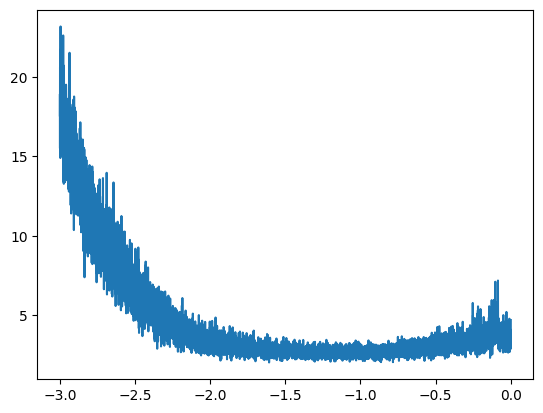

In [240]:
#training
rounds = 10000
training_rate = 1
for _ in range(1):
    #we determined that a good learning rate for our data is in between 0.1 and 1
    lre = torch.linspace(-3,0, rounds) # we create a linear space for the powers
    lri = 10**lre # in the end we want an exponential step
    losses = []
    for current_round in range(rounds):
        ##mini batch
        batch_indexes = torch.randint(0, xs.shape[0], (32,))
        local_xs = xs[batch_indexes]
        local_ys = ys[batch_indexes]
        ##forward
        loss = calculate_loss(parameters, local_xs, local_ys, num_embading_dimensions, embading_size)
        
        #if current_round == 0:
        #    print(f'start loss = {loss}')
        #elif (current_round + 1) == rounds:
        #    print(f'final loss = {loss}')
            
        ##backward
        for p in parameters[1:]:
            p.grad = None
        loss.backward()
    
        ##correction
        for p in parameters[1:]:
            p.data += -lri[current_round]*training_rate * p.grad

        losses.append(loss.item())
    plt.plot(lre, losses)

In [236]:
#use
loss = calculate_loss(parameters, xs, ys, num_embading_dimensions, embading_size)
print(f'total loss = {loss}')

for _ in range(10):
    ixs = [0] * embeding_size
    output = []
    while True:
        prob = forward(parameters, torch.tensor([ixs]), num_embading_dimensions, embading_size)
        ix = torch.multinomial(prob, 1, True, generator=parameters[0]).item()
        if ix == 0:
            break;
        ixs = ixs[1:] + [ix]
        #print(ixs)
        output.append(itos[ix])
    print(''.join(output))

total loss = 2.3193740844726562
imentiiras
uicialina
aren
ans
avangh
ken
onahiey
alan
jaghorto
miki


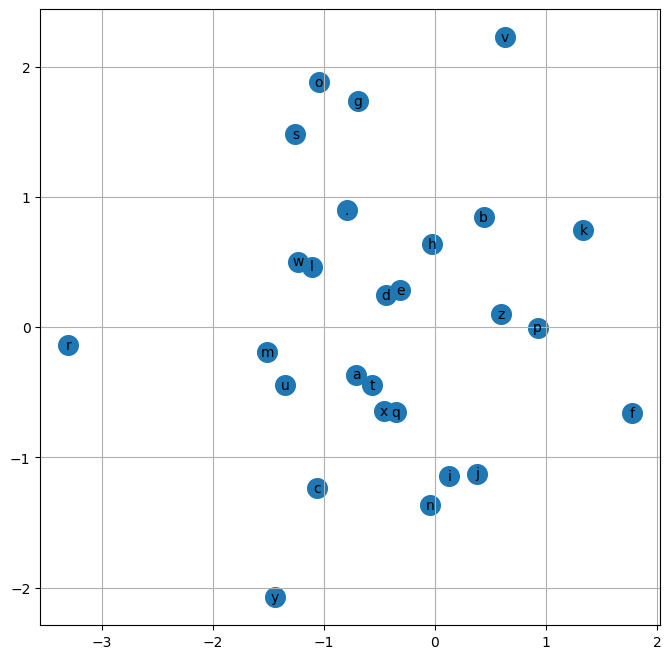

In [229]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha='center', va='center', color='black')
plt.grid('minor')